In [1]:
'''
1. Extract spectrograms from wav files
2. Load training images
3. Build autoencoder 
4. Set threshold
5. Make an inference
'''

'\n1. Extract spectrograms from wav files\n2. Load training images\n3. Build autoencoder \n4. Set threshold\n5. Make an inference\n'

In [1]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [2]:
'''
Read wav files from SOURCE folder, extract spectrograms in JPG format, and save in TARGET folder
'''

'\nRead wav files from SOURCE folder, extract spectrograms in JPG format, and save in TARGET folder\n'

In [3]:
# concurrent.futures — 병렬 작업 실행하기
# 비동기 실행은 (ThreadPoolExecutor를 사용해서) 스레드나 (ProcessPoolExecutor를 사용해서) 별도의 프로세스로 수행 할 수 있습니다. 
# 둘 다 추상 Executor 클래스로 정의된 것과 같은 인터페이스를 구현합니다.
# class concurrent.futures.Executor
#  비동기적으로 호출을 실행하는 메서드를 제공하는 추상 클래스입니다.
#  직접 사용해서는 안 되며, 구체적인 하위 클래스를 통해 사용해야 합니다
# ThreadPoolExecutor
#  ThreadPoolExecutor 는 스레드 풀을 사용하여 호출을 비동기적으로 실행하는 Executor 서브 클래스입니다.
# class concurrent.futures.ThreadPoolExecutor(max_workers=None, thread_name_prefix='', initializer=None, initargs=())
#  최대 max_workers 스레드의 풀을 사용하여 호출을 비동기적으로 실행하는 Executor 서브 클래스.
# We can use a with statement to ensure threads are cleaned up promptly
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL


In [4]:
# https://librosa.org/doc/main/generated/librosa.load.html
# librosa.load(path, *, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
#  Load an audio file as a floating point time series.
#  Audio will be automatically resampled to the given rate (default sr=22050).
#  To preserve the native sampling rate of the file, use sr=None.
#   Parameters:
#    path:      string, int, pathlib.Path, soundfile.SoundFile or file-like object
#    sr:        number > 0 [scalar],    target sampling rate, ‘None’ uses the native sampling rate
#    mono:      bool,                   convert signal to mono
#    offset:    float,                  start reading after this time (in seconds)
#    durationf: loat,                   only load up to this much audio (in seconds)
#    dtype:     numeric type,           data type of y
#    res_type:  str,                    resample type (see note)
#   Returns
#    y:         np.ndarray [shape=(n,) or (…, n)],  audio time series. Multi-channel is supported.
#    sr:        number > 0 [scalar],                sampling rate of y

In [23]:
'''
1. Extract spectrograms from wav files
'''
class SpectrogramExtractor:
    def extract(self, SOURCE, TARGET, FIG_SIZE):
        os.chdir(SOURCE)
        for file in os.listdir(SOURCE):
            # check file extention
            if file.endswith(".wav"):
                # load audio file with Librosa
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    future = executor.submit(librosa.load, file, sr=22050)
                    signal, sample_rate = future.result()

# 푸리에 변환(Fourier transform, FT)은 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환을 말한다.
#  종종 이 변환으로 나타난 주파수 영역에서 함수를 표현한 결과물을 가리키는 용어로도 사용된다.
#  조제프 푸리에가 열전도에 대한 연구에서 열 방정식의 해를 구할 때 처음 사용되었다.

# https://numpy.org/doc/stable/reference/routines.fft.html
# Discrete Fourier Transform (이산 푸리에 변환)
# (numpy.fft)
# SciPy 모듈 scipy.fft는 기본 루틴 세트만 포함하는 numpy.fft의 보다 포괄적인 상위 세트입니다.

# numpy.fft.fft
# fft.fft(a, n=None, axis=- 1, norm=None)[source]
# Compute the one-dimensional discrete Fourier Transform.
# 이 함수는 효율적인 FFT(고속 푸리에 변환) 알고리즘[CT]을 사용하여 1차원 n점 이산 푸리에 변환(DFT)을 계산합니다.

                # perform Fourier transform (FFT -> power spectrum)
                fft = np.fft.fft(signal)

                # calculate abs values on complex numbers to get magnitude
                spectrum = np.abs(fft)

                # create frequency variable
                f = np.linspace(0, sample_rate, len(spectrum))

                # take half of the spectrum and frequency
                left_spectrum = spectrum[:int(len(spectrum)/2)]
                left_f = f[:int(len(spectrum)/2)]

                # STFT -> spectrogram
                hop_length = 512  # in num. of samples
                n_fft = 2048  # window in num. of samples

                # calculate duration hop length and window in seconds
                hop_length_duration = float(hop_length)/sample_rate
                n_fft_duration = float(n_fft)/sample_rate

                # perform stft
                stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

                # calculate abs values on complex numbers to get magnitude
                spectrogram = np.abs(stft)  # np.abs(stft) ** 2

                # apply logarithm to cast amplitude to Decibels
                log_spectrogram = librosa.amplitude_to_db(spectrogram)

                # Matplotlib plots: removing axis, legends and white spaces
                plt.figure(figsize=FIG_SIZE)
                plt.axis('off')
                librosa.display.specshow(
                    log_spectrogram, sr=sample_rate, hop_length=hop_length)
                data_path = pathlib.Path(TARGET)
                file_name = f'{file[0:-4]}.jpg'
                full_name = str(pathlib.Path.joinpath(data_path, file_name))
                plt.savefig(str(full_name), bbox_inches='tight', pad_inches=0)

In [24]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [25]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [26]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    threshold = np.mean(loss) + np.std(loss)
    return threshold

In [27]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [28]:
print(os.getcwd())
print(sys.argv[0])
print(os.path.dirname(os.path.realpath('__file__')))

c:\workspace\autoencoder\autoencoder
C:\Users\astro\anaconda3\envs\ae\lib\site-packages\ipykernel_launcher.py
C:\workspace\autoencoder\autoencoder


In [ ]:
if __name__ == "__main__":

    '''
    1. Extract spectrograms from wav files
    '''
    SOURCE = "C:/workspace/autoencoder/autoencoder/data/in"
    TARGET = "C:/workspace/autoencoder/autoencoder/data/out"
    FIG_SIZE = (20, 20)
    args = [SOURCE, TARGET, FIG_SIZE]

    import time
    start = time.perf_counter()

    extractor = SpectrogramExtractor()
    extractor.extract(SOURCE, TARGET, FIG_SIZE)

    finish = time.perf_counter()
    print(f'Finished in {round(finish-start, 2)} second(s)')

In [20]:
    '''
    2. Load training images
    '''
    data_path = "C:/workspace/autoencoder/autoencoder/data/x_train"
    x_train = create_training_data(data_path)

    data_path = "C:/workspace/autoencoder/autoencoder/data/x_test"
    x_test = create_training_data(data_path)

In [21]:
    '''
    3. Build autoencoder 
    '''
    autoencoder = Autoencoder(latent_dim=64 * 2)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    history = autoencoder.fit(x_train, x_train,
                              epochs=10,
                              shuffle=True,
                              validation_data=(x_test, x_test))

Epoch 1/10
4/4 [==============================] - 0s 39ms/step - loss: 0.0846 - val_loss: 0.0469
Epoch 2/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0311 - val_loss: 0.0094
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 5/10
4/4 [==============================] - 0s 13ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/10
4/4 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 10/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0066


In [22]:
    # a summary of architecture
    autoencoder.encoder.summary()
    autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6422656   
                                                                 
Total params: 6,422,656
Trainable params: 6,422,656
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50176)             6472704   
                                                                 
 reshape_1 (Reshape)         (None, 224, 224)          0         
                                                                 
Total params: 6,472,70

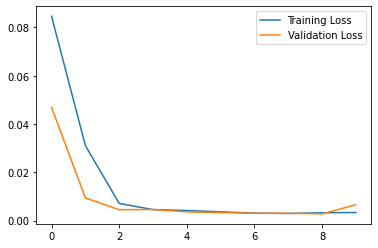

In [23]:
    # plot history
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

In [24]:
    # save and load a mode
    autoencoder.save('./model/')
    autoencoder = keras.models.load_model('./model/')

INFO:tensorflow:Assets written to: ./model/assets


In [25]:
    # load autoencoder model
    if autoencoder is None:
        autoencoder = Autoencoder(latent_dim=64 * 2)
        autoencoder = keras.models.load_model('./model/')

In [26]:
    '''
    4. Set threshold
    '''
    threshold = model_threshold(autoencoder, x_train)
    # loss = tf.keras.losses.mse(decoded_imgs, x_train)
    # threshold = np.mean(loss) + np.std(loss)
    print("Loss Threshold: ", threshold)

    # load autoencoder model
    if autoencoder is None:
        autoencoder = keras.models.load_model('./model/')

Loss Threshold:  0.008343884878976564


Loss is bigger than threshold 
           Sample Loss: 0.030893877148628235 
           Threshold: 0.008343884878976564 


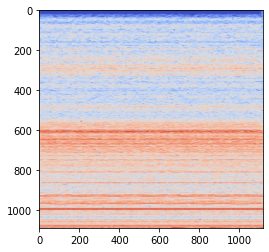

In [29]:
    '''
    5. Make an inference
    '''
    # get statistics for each spectrogram
    #file = 'C:/workspace/autoencoder/autoencoder/data/sample_0.jpg'
    #file = 'C:/workspace/autoencoder/autoencoder/data/sample_1.jpg'
    #file = 'C:/workspace/autoencoder/autoencoder/data/sample_2.jpg'
    file = 'C:/workspace/autoencoder/autoencoder/data/x_test/engine1_good/pure_101.jpg'
    file = 'C:/workspace/autoencoder/autoencoder/data/x_test/engine2_broken/pure_0.jpg'
    sample = plt.imread(file)
    plt.imshow(sample)
    sample = pathlib.Path(file)
    sample_loss = spectrogram_loss(autoencoder, sample)

    if sample_loss > threshold:
        print(
            f'Loss is bigger than threshold \n \
              Sample Loss: {sample_loss} \n \
              Threshold: {threshold} ')
    else:
        print(
            f'Loss is smaller than threshold \n \
              Sample Loss: {sample_loss} \n \
              Threshold: {threshold} ')